In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import Sequential, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

**Listing the image directories**

In [2]:
data_dir = r'/kaggle/input/covid-pneumonia-normal-chest-xray-images'

classes = os.listdir(data_dir)
print(classes)

['COVID', 'NORMAL', 'PNEUMONIA']


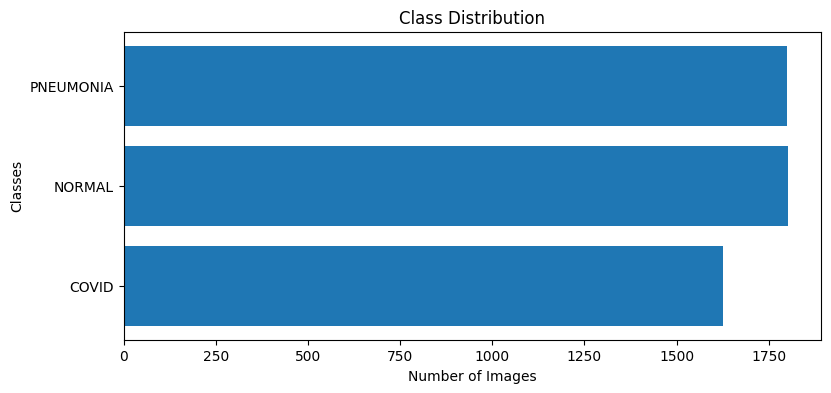

In [3]:
from collections import Counter

# Count images per class
class_counts = Counter()
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(9, 4))
plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.xlabel('Number of Images')  # Number of Images should be on the x-axis
plt.ylabel('Classes')           # Classes should be on the y-axis
plt.title('Class Distribution')
plt.show()

**Printing sample images from each classes**

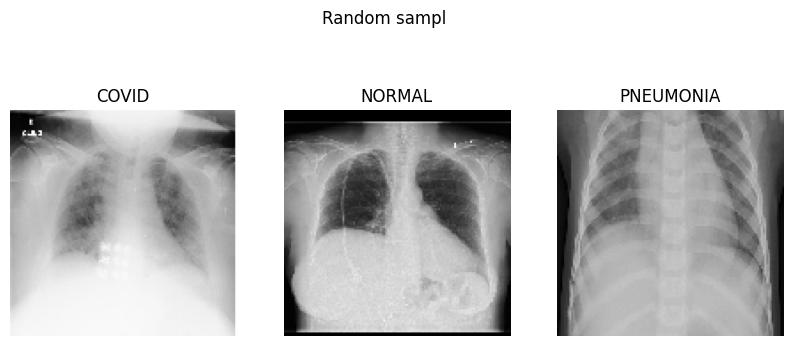

In [4]:
class_dirs = os.listdir(data_dir)
plt.figure(figsize=(10, 10))
for i, cls in enumerate(class_dirs, start=1):
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle('Random sampl')
plt.show()


**Creating a Tensorflow dataset**

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size = (256,256),
    batch_size = 32,
    labels='inferred',
    label_mode='int'
)

Found 5228 files belonging to 3 classes.


**Classes**

In [6]:
class_names = dataset.class_names
print("class :",class_names)
# Length of batches
print("Length of batches :",len(dataset))

class : ['COVID', 'NORMAL', 'PNEUMONIA']
Length of batches : 164


**Splitting above tf dataset**

In [7]:
# Let's define a function for train val test split
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # Get dataset size
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset


train_ds, val_ds, test_ds = split_dataset(dataset)

**check the split**

In [8]:
print("train_ds :",len(train_ds))
print("val_ds :",len(val_ds))
print("test_ds :",len(test_ds))

train_ds : 131
val_ds : 16
test_ds : 17


**Optimize the data pipeline for training machine learning models**

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Defining pipeline for resizing, rescaling/normalizing the data and for data augmentation**

In [10]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

**Define a CNN model**

In [11]:
model = Sequential()

# Apply resize_and_rescale and data augmentation
resize_and_rescale,

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))

c:\Users\Nour Hesham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    67,109,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,515,011 (257.55 MB)

 Trainable params: 67,514,115 (257.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [51]:
history = model.fit(train_ds, epochs = 16, batch_size = 32, verbose = 1, validation_data = val_ds)
history1 = model.fit(train_ds, epochs = 4, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/16


In [17]:
loss,acc=model.evaluate(test_ds,verbose=0)
print("Lose :",loss)
print(f"Accuracy :{100*acc:.2f} %")

Lose : 0.8747590184211731
Accuracy :96.14 %


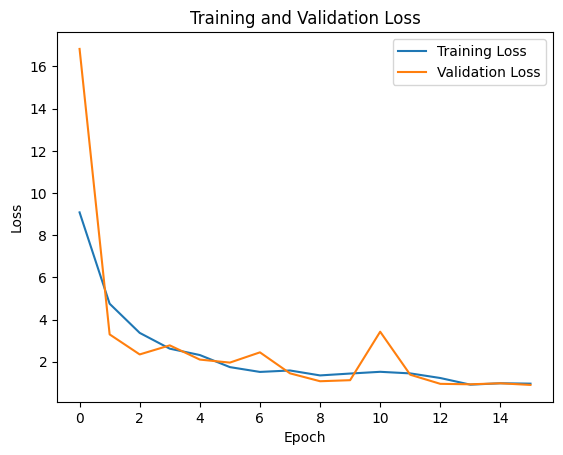

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

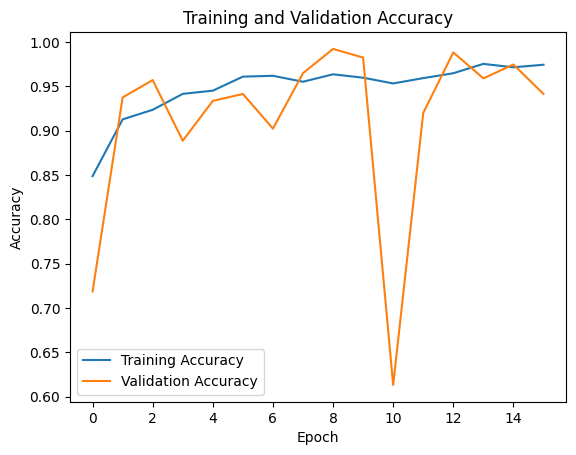

In [19]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
y_pred_probs = model.predict(test_ds)
print(y_pred_probs)

17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
[[1.2511872e-01 8.6282790e-01 1.2053332e-02]
 [6.9428725e-06 1.2897156e-05 9.9998021e-01]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.8781433e-22 1.0000000e+00]
 [1.0441374e-02 9.6849883e-01 2.1059845e-02]]


The predicted output is the probability of the image belonging to each separate class,this is due to softmax

In [21]:
y_pred = np.argmax(y_pred_probs, axis=1)  # This returns which column has the highest value
print(y_pred)

[1 2 2 0 0 0 0 0 2 2 1 1 2 0 1 1 2 2 2 2 2 0 2 2 0 0 0 2 1 1 1 0 0 0 0 2 2
 2 0 0 0 0 0 2 1 0 2 2 2 2 0 2 0 0 0 1 0 1 2 0 0 2 2 0 1 0 2 0 0 1 0 0 1 2
 2 0 2 1 1 2 1 0 0 1 1 1 0 1 1 0 1 0 2 2 0 0 1 0 2 1 2 2 1 2 0 0 2 2 1 2 0
 1 1 2 2 0 0 2 1 1 0 2 2 0 2 1 2 2 1 1 2 1 1 1 2 2 1 1 1 2 0 0 2 1 0 0 0 0
 2 0 0 2 0 1 2 1 2 1 0 2 1 0 0 2 0 0 0 0 0 1 2 1 0 1 0 0 1 1 2 1 1 0 0 1 2
 1 1 2 2 1 2 2 1 1 0 2 2 0 2 0 0 2 2 2 0 2 2 2 1 0 1 0 1 1 1 1 0 0 2 2 1 1
 2 1 2 2 0 1 0 0 2 1 2 0 1 0 2 1 0 2 1 2 1 2 0 2 2 0 0 1 0 1 2 2 2 0 0 1 2
 1 1 2 1 1 0 2 1 1 1 1 2 1 0 2 0 2 1 0 2 1 2 2 0 2 2 2 2 1 2 0 0 1 0 0 1 2
 0 2 2 2 2 2 0 1 1 2 2 0 2 2 0 1 0 1 0 2 0 1 1 1 1 2 2 2 1 1 0 1 0 2 2 1 2
 1 0 1 1 0 2 1 1 0 0 1 2 1 2 1 2 2 2 2 1 0 1 0 1 2 0 1 2 0 0 1 1 2 2 0 0 0
 2 1 2 1 1 1 1 2 1 1 0 0 1 0 2 1 1 1 1 0 2 1 2 2 0 0 2 0 2 0 0 0 0 0 0 2 2
 2 1 2 1 0 0 2 2 2 2 2 0 2 2 0 0 0 0 0 1 2 0 2 0 0 0 1 2 2 2 0 0 0 1 2 2 0
 0 2 2 0 1 2 2 2 1 1 1 0 1 2 2 0 2 1 0 2 1 1 1 1 1 1 1 1 0 1 0 1 1 1 2 1 0
 0 0 1 2 2 0 0 0 2 2 1 1 

[](http://)

**Make predictions on some sample images**

First image predicted
First image actual label:  COVID
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label:  COVID


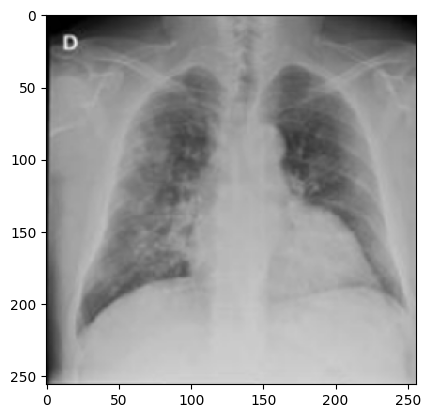

In [49]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')  # [0] gives the first image of the batch 1, 2, 3, for 2nd, 3rd ....
    first_label = labels_batch[0].numpy()
    
    print('First image predicted')
    plt.imshow(first_image)
    print('First image actual label: ', class_names[first_label]) #class_names gives the names instead of 0,1 or 2
    
    batch_prediction = model.predict(images_batch)   # This is the prediction of all 32 images of the first batch
    print('Predicted label: ' , class_names[np.argmax(batch_prediction[0])])   # this is the prediction of the first image
    
    # Each time we run this, we'll get a new image due to shuffle in ds.take()

**Define a function to show the **prediction confidence**

In [50]:
# We do this to predict the model on a random image(beyond the dataset, now we're defining a function
def predict(model, img): # A function which takes model and image as input
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())   # convert image into image array
    img_array = tf.expand_dims(img_array, 0)    # create a batch out of it

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Let's run the prediction on the 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


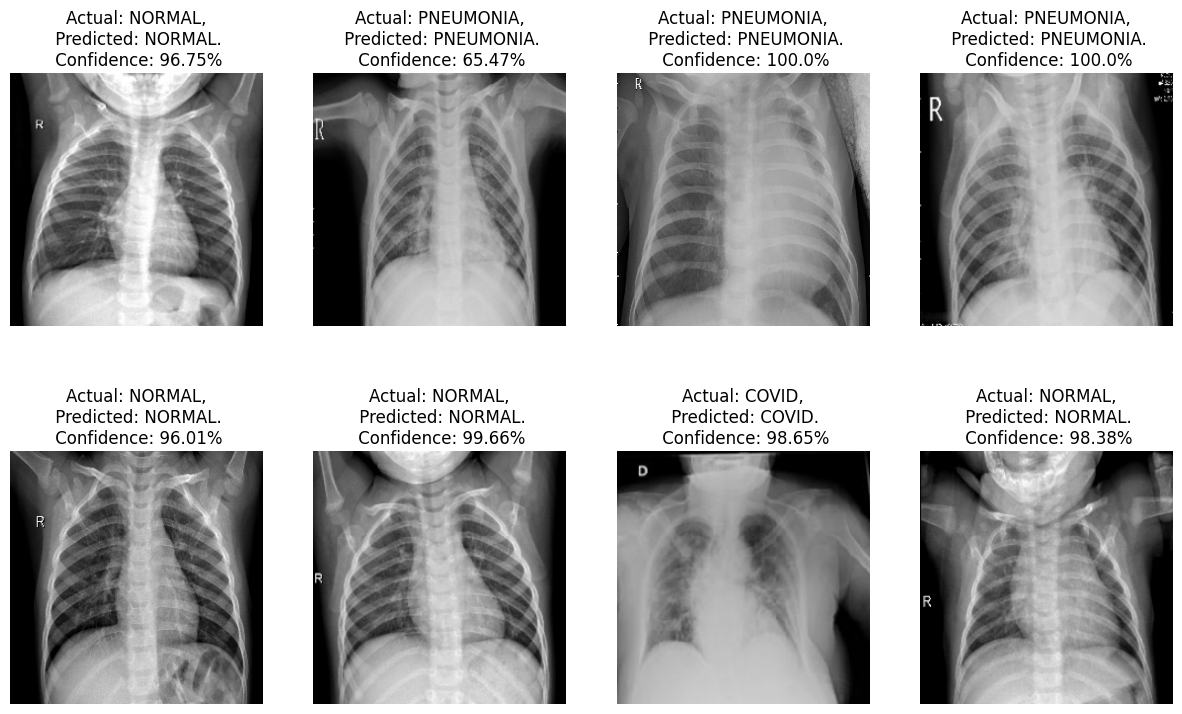

In [28]:
plt.figure(figsize=(15, 9))
for images, labels in test_ds.take(2):
    for i in range(8):     # picking first 9 images from the batch
        ax = plt.subplot(2, 4, i + 1)  # subplot to show all the images
        plt.imshow(images[i].numpy().astype("uint8"))   # Show the image
        
        predicted_class, confidence = predict(model, images[i].numpy())  # Using above defined function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")  # Turn off the grid

In [45]:
total_prediction = 0  
correct_prediction = 0


for images_batch, labels_batch in test_ds:
    
    
    batch_prediction = model.predict(images_batch)   # This is the prediction of all 32 images of the first batch
    predicted_labels = np.argmax(batch_prediction,axis=1)
    correct_prediction += np.sum(predicted_labels == labels_batch.numpy())
    total_prediction += len(labels_batch)    



print( f"total_prediction :{total_prediction}\n",
      f"correct prediction :{correct_prediction}\n",
      f"incorrect_prediction :{total_prediction - correct_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
total_prediction :544 correct prediction :523
 incorrect_prediction :21



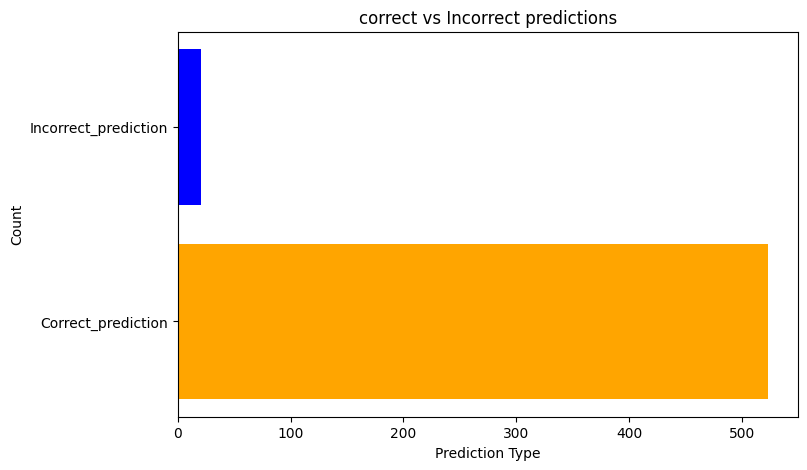

In [48]:
incorrect_prediction = total_prediction - correct_prediction
labels = ['Correct_prediction' , 'Incorrect_prediction']
values = [correct_prediction , incorrect_prediction]
plt.figure(figsize=(8,5))
plt.barh(labels,values,color=['orange','blue'])
plt.xlabel('Prediction Type')
plt.ylabel('Count')
plt.title('correct vs Incorrect predictions')
plt.show()